In [71]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import calinski_harabasz_score, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import helper_funcs as my_funcs
import math
%matplotlib inline

In [16]:
device_fp = pd.read_csv("DBVersions/device_fp.csv", index_col=0)
pce = pd.read_csv("DBVersions/clarke_DSSCDB.csv")["PCE"]
pce

0       5.19
1       2.60
2       3.10
3       2.20
4       5.00
        ... 
4421    8.79
4422    4.52
4423    6.09
4424    5.65
4425    5.21
Name: PCE, Length: 4426, dtype: float64

In [21]:
def bic_score(X, labels):
  """
  BIC score for the goodness of fit of clusters.
  This Python function is directly translated from the GoLang code made by the author of the paper. 
  The original code is available here: https://github.com/bobhancock/goxmeans/blob/a78e909e374c6f97ddd04a239658c7c5b7365e5c/km.go#L778
  """
    
  n_points = len(labels)
  n_clusters = len(set(labels))
  n_dimensions = X.shape[1]

  n_parameters = (n_clusters - 1) + (n_dimensions * n_clusters) + 1

  loglikelihood = 0
  for label_name in set(labels):
    X_cluster = X[labels == label_name]
    n_points_cluster = len(X_cluster)
    centroid = np.mean(X_cluster, axis=0)
    variance = np.sum((X_cluster - centroid) ** 2) / (len(X_cluster) - 1)
    loglikelihood += \
      n_points_cluster * np.log(n_points_cluster) \
      - n_points_cluster * np.log(n_points) \
      - n_points_cluster * n_dimensions / 2 * np.log(2 * math.pi * variance) \
      - (n_points_cluster - 1) / 2
    
  bic = loglikelihood - (n_parameters / 2) * np.log(n_points)
        
  return bic

<Axes: xlabel='k', ylabel='Calinski-Harabasz Score'>

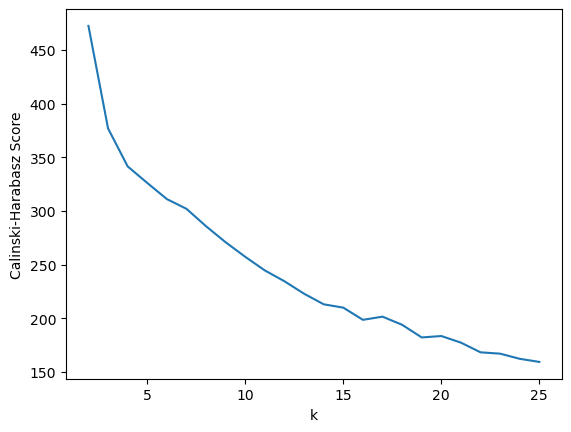

In [24]:
k_search = dict()
k_lst = []
ch_lst = []
for k in range(2, 26):
    k_lst.append(k)
    k_means = KMeans(n_clusters=k, n_init=15)
    k_means.fit(device_fp)
    ch_score_ = calinski_harabasz_score(device_fp, k_means.labels_)
    ch_lst.append(ch_score_)

k_search["k"] = k_lst
k_search["Calinski-Harabasz Score"] = ch_lst
k_means_df = pd.DataFrame.from_dict(data=k_search)
sns.lineplot( data=k_means_df, x="k", y="Calinski-Harabasz Score")

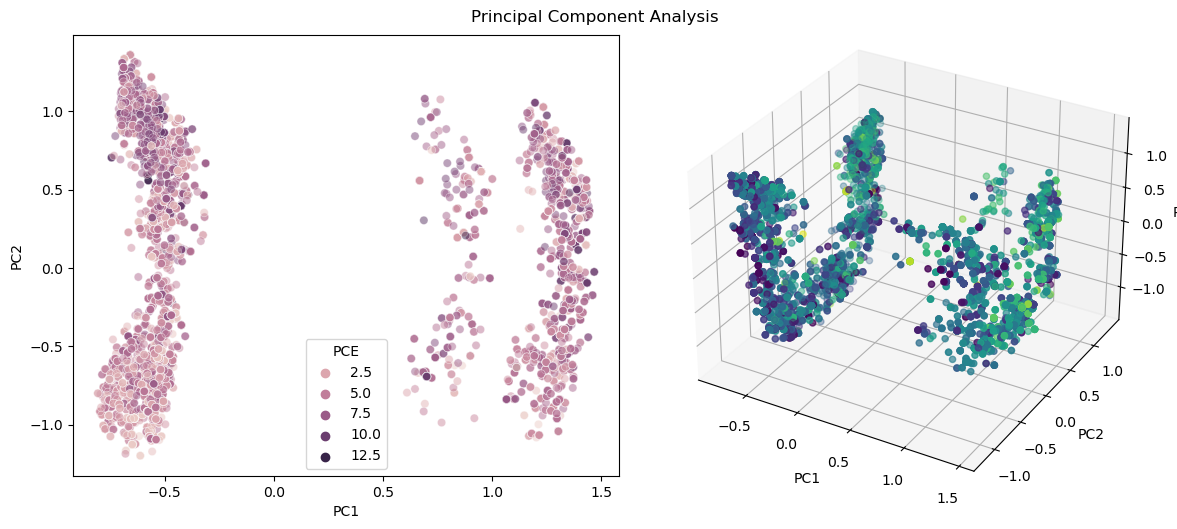

In [44]:
component_names = ["PC1", "PC2", "PC3"]

pca = PCA(n_components=3) # kernel='rbf', gamma=1e-3, fit_inverse_transform=True, alpha=5e-3) # 

device_pca_anal = pd.DataFrame(data=pca.fit_transform(device_fp), columns=component_names)
device_pca = pd.DataFrame(data=pca.fit_transform(device_fp))

# ---- k_means ----


device_pca_pce = pd.concat([device_pca_anal, pce], axis="columns")

my_funcs.pca_dashboard(original_data=device_fp, pca=pca, pca_data=device_pca_pce, hue="PCE")


In [13]:
tsne_components = ['Component1', 'Component2']

pca_tsne = KernelPCA(n_components=50)

embedded_devices = TSNE(n_components=2, method='exact', init='random', perplexity=50).fit_transform(device_fp)

tsne_devices = pd.DataFrame(data=embedded_devices, columns=tsne_components)
tsne_devices_pce = pd.concat([tsne_devices, pce], axis='columns')
tsne_devices_pce

,Component1,Component2,PCE
0,73.041733,4.300115,5.19
1,56.391777,8.819344,2.60
2,56.391777,8.819344,3.10
3,56.391777,8.819344,2.20
4,56.330723,7.641580,5.00
...,...,...,...
4421,47.941475,33.888210,8.79
4422,48.140369,33.602318,4.52
4423,48.140369,33.602318,6.09
4424,48.139969,33.601772,5.65


<Axes: xlabel='Component1', ylabel='Component2'>

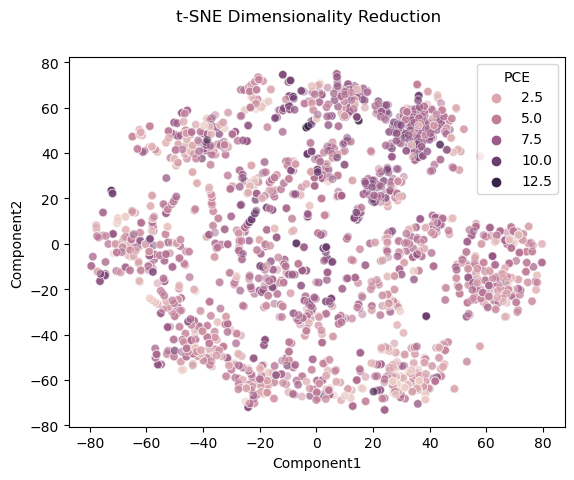

In [14]:
fig, axes = plt.subplots()
fig.suptitle("t-SNE Dimensionality Reduction")
sns.scatterplot(ax=axes, data=tsne_devices_pce, x="Component1", y="Component2", hue="PCE", alpha=0.5)


In [82]:
X_train, X_test, Y_train, Y_test = train_test_split(device_fp, pce, test_size=0.2, random_state=42)

rf_reg = RandomForestRegressor(n_estimators=200)

rf_reg.fit(X_train, Y_train)

pred_train = rf_reg.predict(X_train)
pred_test = rf_reg.predict(X_test)

train_df = pd.DataFrame.from_dict({'True': Y_train, 'Predicted': pred_train})
test_df = pd.DataFrame.from_dict({'True': Y_test, 'Predicted': pred_test})


# ---- train results ----
r2 = r2_score(Y_train, pred_train)
train_mae = mean_absolute_error(Y_train, pred_train)

# ---- test results ----
q2 = r2_score(Y_test, pred_test)
test_mae = mean_absolute_error(Y_test, pred_test)

Text(0.5, 1.0, 'Test Set: q2 -> 0.58, mae -> 1.18')

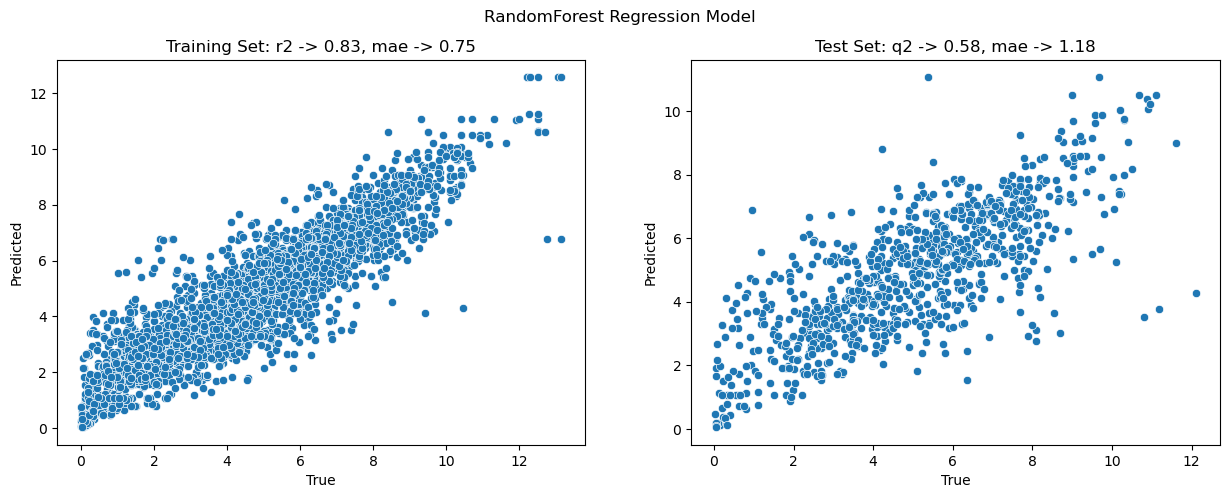

In [83]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
fig.suptitle('RandomForest Regression Model')

# Training Set Results
sns.scatterplot(ax=axes[0], data=train_df, x='True', y='Predicted')
axes[0].set_title(f"Training Set: r2 -> {round(r2,2)}, mae -> {round(train_mae, 2)}")

# Test Set Results
sns.scatterplot(ax=axes[1], data=test_df, x='True', y='Predicted')
axes[1].set_title(f"Test Set: q2 -> {round(q2, 2)}, mae -> {round(test_mae, 2)}")